In [1]:
import numpy as np
from scipy import fft, ifft
from scipy import signal
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

from obspy.io.segy import segy

import lasio

% matplotlib inline

## Get Seismic

In [2]:
%run wavelet_utils/wavelet_utils.py

In [3]:
segy = 'data/XL_1153_Penobscot.segy'
data = get_seismic(segy)
dt = get_sample_rate_in_seconds(segy)

## Get logs

In [4]:
# Acoustic Impedance
L30 = lasio.read('data/L-30.las')

/Users/Evan/anaconda/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [5]:
def f2m(item_in_feet):
    "converts feet to meters"
    try:
        return item_in_feet / 3.28084
    
    except TypeError:
        return float(item_in_feet) / 3.28084
    
    return converted

In [6]:
# depth
z = f2m(L30['DEPTH'])      # convert feet to metres
# P-velocity in SI units
Vp = 1e6 / (L30['DT']*3.28084)     # convert usec/ft to usec/m
# bulk density in SI units
RHOB = L30['RHOB']*1000    # convert to SI units
# Acoustic Impedance in SI units
Zp = Vp * RHOB

## Get t-d relationship

In [7]:
tdr = np.nan_to_num(np.loadtxt('data/L-30_t-d', skiprows=1))
maxt = 4.0 # max time for time-depth relationship interpolator

In [8]:
# resample t-d relationship 
tt = tdr[:,3] # np.arange(0, maxt, dt)
zz = tdr[:,0]
tvals = np.arange(0, 1000*maxt, 1000*dt)
zinterp = np.interp(tvals, tt, zz)

After [Matt Hall's interpolation tutorial](https://github.com/seg/tutorials/blob/master/1604_Function_of_interpolation/The_function_of_interpolation.ipynb), make an interpolator function, then call it for some time that does not have a sample associated with it.

In [9]:
t2d = interp1d(zz, tt, kind='linear', bounds_error=False)
print (t2d(4250))

3097.0


In [10]:
twt = t2d(z)

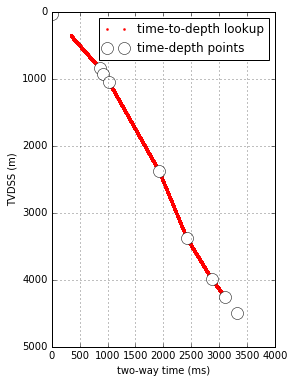

In [11]:
plt.figure(figsize=(4,6))
# plt.plot(xvals[::10], yinterp[::10], 'k.')
plt.plot(twt,z,'r.', ms=4, label='time-to-depth lookup')
plt.ylabel('TVDSS (m)'), plt.xlabel('two-way time (ms)')
plt.plot(tt, zz, 'wo', ms=12, label='time-depth points')
plt.xlim(0,4000)
plt.ylim(5000,0)
plt.grid()
plt.legend()
plt.show()

## Reflectivity in time domain

In [12]:
t = np.arange(0, 1000*maxt, 1000*dt)
Zp_twt = np.interp(x = t, xp = twt, fp = Zp)
r = (Zp_twt[1:] - Zp_twt[:-1]) / (Zp_twt [1:] + Zp_twt [:-1])
r = np.nan_to_num(r)  # convert nans to zeros


In [106]:
np.savetxt('wave_est/r.npy',r)
np.savetxt('wave_est/s.npy', data[:,100])

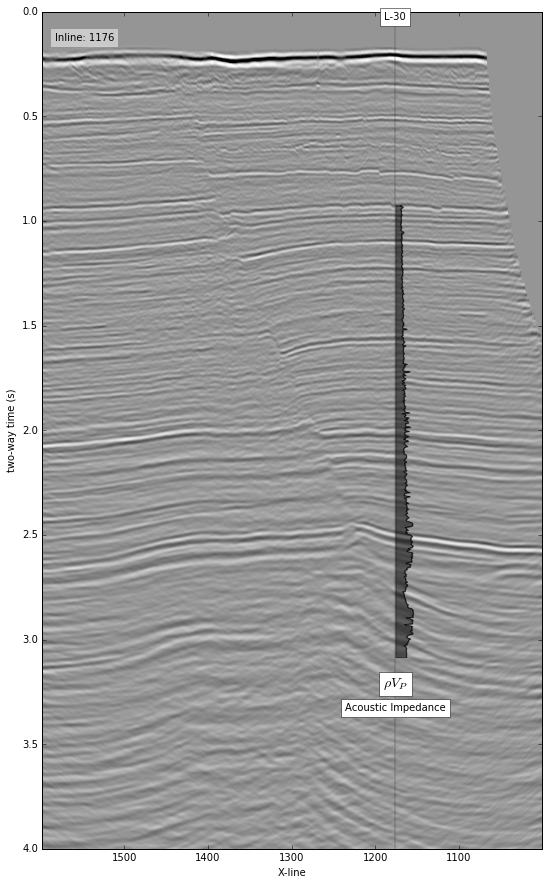

In [14]:
%run wavelet_utils/wavelet_utils.py
seismic_and_well_plot(data, log=0.025*Zp_twt/1e6, t_r=t/1000)

## 1. Wavelet estimation by visual inspection

Let's look at the spectra of our seismic data in and try to choose the corner frequencies `(f1, f2, f3, f4)` for an Ormsby wavelet.

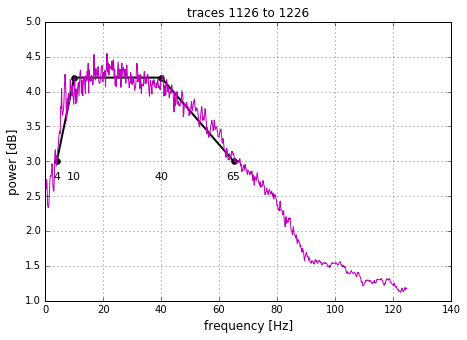

In [15]:
S, ax = get_spectrum(data, x=100, dt=dt, ilx=1176, r=50)
freqs = [4,10,40,65]
c = 1.0
p = c*np.array([3.0,4.2,4.2,3.0])
ax.plot(freqs, p, 'ko-', lw=2, zorder=0, ms=6)
for f in freqs:
    ax.text(f,0.95*p[0],f, ha='center', va='top', fontsize=11)

### Make an ormsby wavelet using Bruges

In [16]:
from bruges.filters.wavelets import ormsby, ricker

In [17]:
duration = 0.256 # seconds
freq_rick=32
# Ormsby
orms = ormsby(duration, dt=0.004, f=freqs)
# Let's get a Ricker while, we're at it.
ricker = ricker(duration, dt, freq_rick)
tw = np.arange(-len(ricker)//2,len(ricker)//2,1)*dt

### Plot the Ormsby and Ricker wavelet

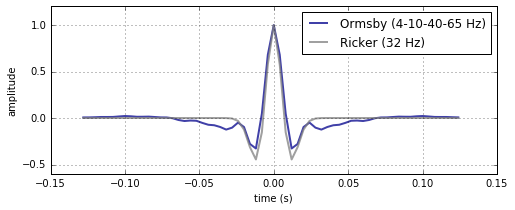

In [18]:
fig =plt.figure(figsize=(8,3))
# plot Ormsby wavelet
plt.plot(tw, orms, 'darkblue', lw=2, alpha=0.75, 
         label='Ormsby (%i-%i-%i-%i Hz)' %(freqs[0],freqs[1],freqs[2],freqs[3]))
# plot Ricker wavelet
plt.plot(tw, ricker, 'grey', lw=2, alpha=0.75, 
         label='Ricker (%i Hz)' % (freq_rick))
plt.legend(loc=1)
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.grid()

In [22]:
w1 = orms

In [23]:
s1 = np.convolve(w1, r, mode='same')

In [49]:
def plot_imp_refl_synth(t, Zp, r, w, d, dt):
    s = np.convolve(w1, r, mode='same')
    ylim = (0,4100)
    
    figure = plt.figure(figsize=(6,15))
    ax1 = figure.add_subplot(141)
    ax1.plot(Zp_twt, t, lw=0.5)
    ax1.set_ylim(ylim[-1],ylim[0])
    ax1.set_ylabel('two-way time (ms)')
    ax1.grid()

    ax2 = figure.add_subplot(142)
    ax2.plot(r, t[:-1],'k', lw=0.5)
    ax2.set_ylim(ylim[-1],ylim[0])
    ax2.set_xlim(-1,1)
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])

    ax2.grid()

    ax3 = figure.add_subplot(143)
    c = 0.5
    n = 5
    for i in range(n):
        ax3.plot(s+c*i, t[:-1],'k', lw=0.5)
        ax3.fill_betweenx(t[:-1], s+c*i, c*i,
                          s+c*i > c*i, color='k', alpha=1.0)
    ax3.set_ylim(ylim[-1],ylim[0])
    ax3.set_xlim(-0.5*c,c*(n-0.5))
    ax3.set_yticklabels([])
    ax3.set_xticklabels([])
    ax3.grid()

    ax4 = figure.add_subplot(144)
    dg = 1.0
    tdata = 1000*np.arange(0,len(d))*dt
    for i in range(0,n,1):
        ax4.plot(norm(d[:,i])/dg+dg*i, tdata,'k', lw=0.5)
        ax4.fill_betweenx(tdata, norm(d[:,i])/dg+dg*i, dg*i,
                          norm(d[:,i])/dg +dg*i > dg*i, color='k', alpha=1.0)
    ax4.set_ylim(ylim[-1],ylim[0])
    ax4.set_xlim(-c,2*(n-0.5)*c)
    ax4.set_yticklabels([])
    #ax4.set_xticklabels([])
    ax4.grid()

    return

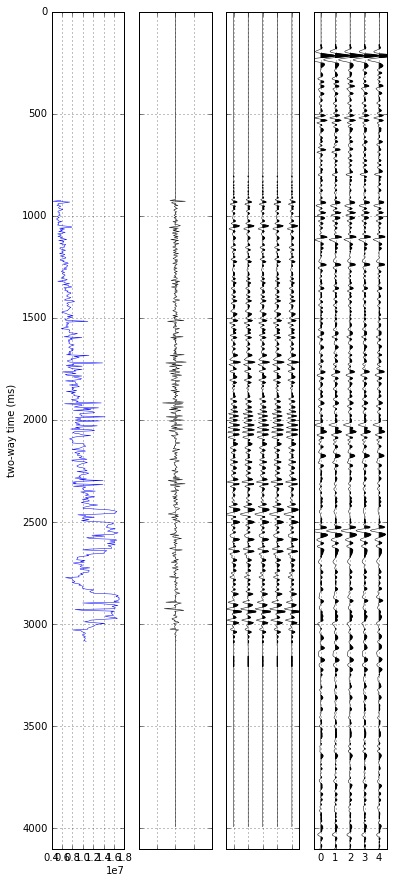

In [50]:
plot_imp_refl_synth(t, Zp_twt, r, w1, data[:,100:121], dt)

## 2. Wavelet estimation by autocorrelation

In [51]:
from ipywidgets import interact

In [52]:
x =100
n1 = 250 # first time sample
dn = 450 # number of time samples
dw = 64 # length of wavelet (in time samples 0.256 s)

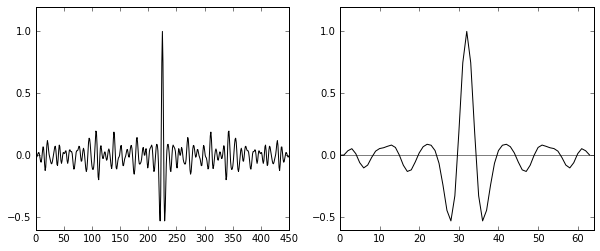

In [53]:
@interact(n1=(0, 500), dn=(300,600))
def plot_trace(n1,dn):
    trace = norm(data[n1:n1+dn, x])
    r_crop = r[n1:n1+dn]

    acorr = np.correlate(norm(trace), norm(trace), mode='same')
    w2 = acorr[len(trace)//2-dw//2:len(trace)//2+dw//2]

    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(121)
    ax.plot(norm(acorr),'k')
    ax2 = fig.add_subplot(122)
    ax2.plot(norm(w2),'k')
    ax2.set_xlim(0,64)
    ax2.axhline(0,color='k',alpha=0.5)

In [54]:
trace = norm(data[n1:n1+dn, x])
r_crop = r[n1:n1+dn]
acorr = np.correlate(norm(trace), norm(trace), mode='same')
w2 = norm(acorr[len(trace)//2-dw//2:len(trace)//2+dw//2])

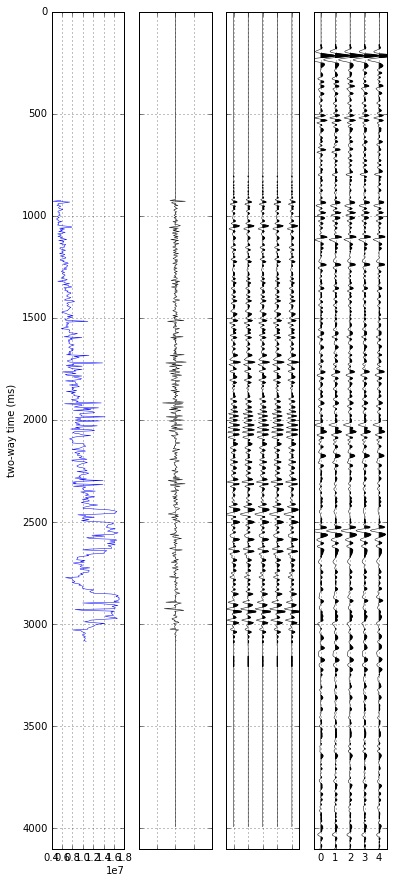

In [55]:
plot_imp_refl_synth(1000*np.arange(0,len(Zp_twt),1)*dt,Zp_twt, r, w2, data[:,100:121], dt)

Note autocorrelation can also be done as

`fft(s_crop)*fft(s_crop).conjugate()`

In [56]:
W2 = fft(w2)
fax =  get_faxis(w2,dt)

<b>Let's look at the power spectrum relative to our Ormsby corner frequencies<b>

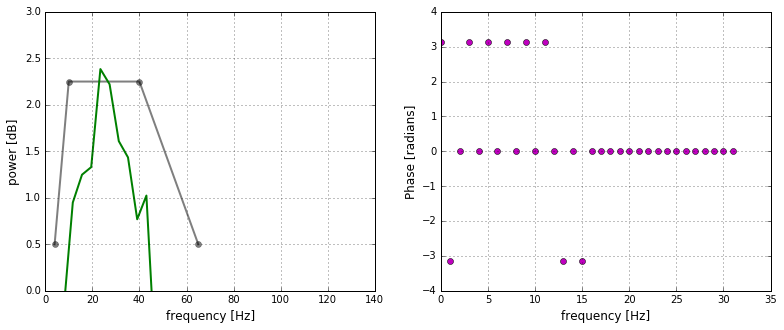

In [62]:
Y = np.log10(abs(W2[:len(fax)//2]))
Ps = np.angle(np.fft.fft(w2))

fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(121)
ax.plot(fax[:len(fax)//2], Y*3,'g', lw=2)
ax.set_xlabel('frequency [Hz]', fontsize=12)
ax.set_ylabel('power [dB]', fontsize=12)
ax.set_ylim(0,3)
ax.grid()
ax.plot(freqs, [0.5, 2.25, 2.25, 0.5], 'ko-', lw=2, zorder=0, ms=6, alpha=0.5)

ax2 = fig.add_subplot(122)
ax2.plot(Ps[:len(Ps)//2], 'mo', lw=1)
ax2.set_xlabel('frequency [Hz]', fontsize=12)
ax2.set_ylabel('Phase [radians]', fontsize=12)
ax2.grid()

## 3. Wavelet estimation by spectral division

In [63]:
def spectral_division(rpp, seismic):
    
    seis_fft = np.fft.fft(seismic)
    ref_fft = np.fft.fft(rpp)
    wavelet_spec = seis_fft / ref_fft
    wavelet_div = np.fft.ifft(wavelet_spec)
    
    return wavelet_div

/Users/Evan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


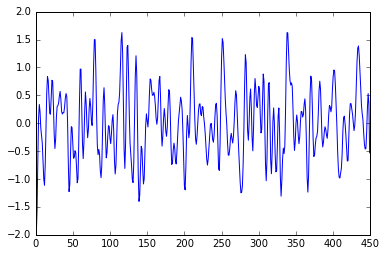

In [67]:
w3 = spectral_division(r_crop, trace)
plt.figure()
plt.plot(w3)

Both methods give more or less gibberish, which basically shows that migrated seismic does not adhere to a convolutional model. Let's check the Spectra.


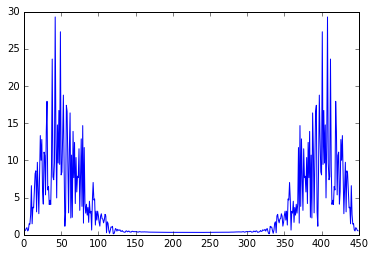

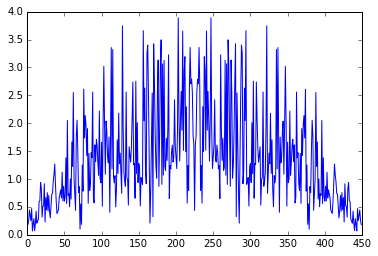

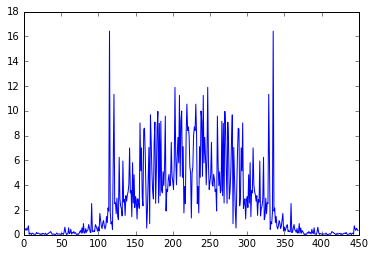

In [68]:
plt.figure()
plt.plot(np.abs(np.fft.fft(trace)))
plt.figure()
plt.plot(np.abs(np.fft.fft(r_crop)))
plt.figure()
plt.plot(np.abs(np.fft.fft(r_crop) / np.fft.fft(trace)))

Gross. Tons of variance and a spectrum that looks nothing like a wavelet. Basically we can't fit the data because a convolutional model sucks at modelling migrated seismic. Let's use some optimization tricks. Regularize the least squares problem and bias it towards an answer we want. Start with something simple, like an L2 norm. Basically we know a priori that we don't want ton of large spikes in our wavelet and an L2 norm will penalize these. Note ridge regression is just least-squares with an L2 penalty.

In [69]:
from scipy import linalg as la
from sklearn import linear_model

/Users/Evan/anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [70]:
t = np.arange(0,dw*dt,dt)

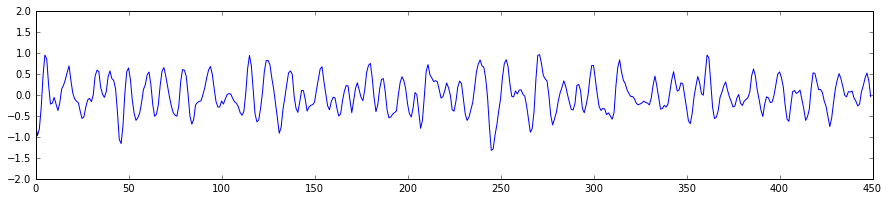

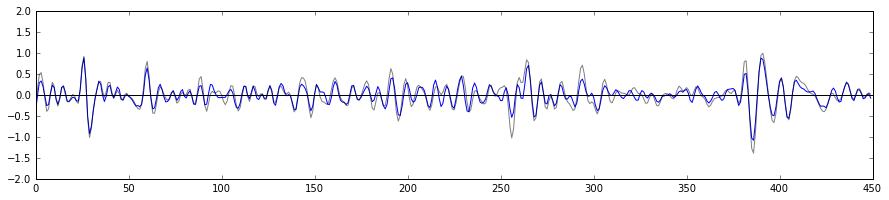

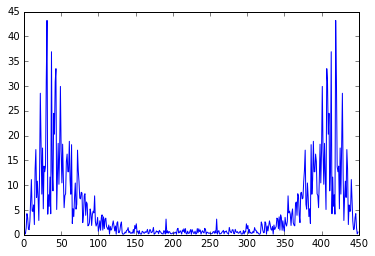

In [76]:
clf = linear_model.Ridge(alpha=0.05)
#clf = linear_model.Lasso(alpha = 0.1)
#clf = linear_model.BayesianRidge(n_iter=300000, alpha_1=0.5, fit_intercept=False)
#clf = linear_model.RidgeCV()

opConvolve = la.toeplitz(r_crop)
op  = opConvolve
clf.fit(op, trace)
wavelet_new = clf.coef_

plt.figure(figsize=(15,3))
plt.plot(wavelet_new)
s5 = np.dot(op, wavelet_new)
plt.ylim([-2,2])
# modelled seismic

plt.figure(figsize=(15,3))
plt.plot(np.dot(op, wavelet_new),'b')
plt.axhline(0, color='k')
plt.plot(trace, 'k', alpha=0.5)
#plt.axhline(1, color='k')
plt.ylim([-2,2])

# Check the spectra
plt.figure()
plt.plot(np.abs(np.fft.fft(wavelet_new)))

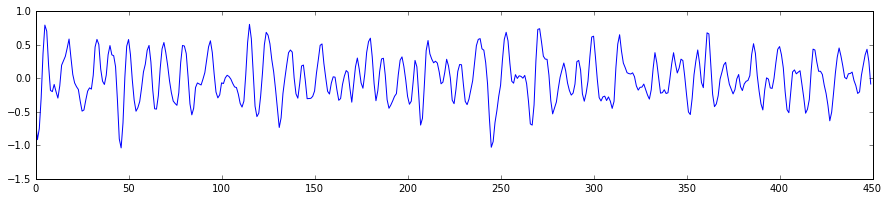

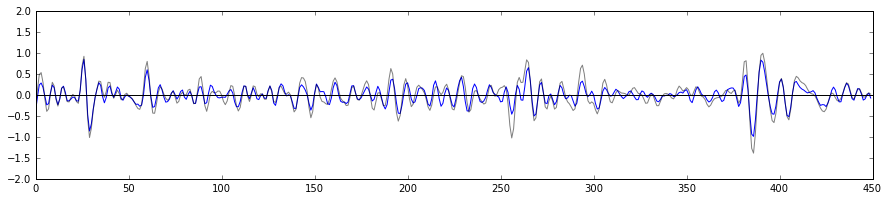

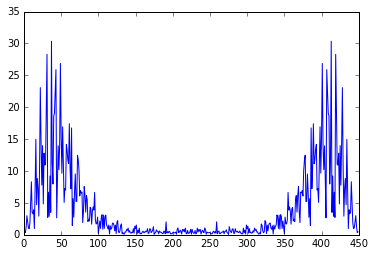

In [80]:
# plotting stuff
@interact(a=(0.0,1.00,0.0001))
def plot_synthetics(a=0.5):
    clf = linear_model.Ridge(alpha=a)
    #clf = linear_model.Lasso(alpha = 0.001)
    #clf = linear_model.BayesianRidge(n_iter=300000, alpha_1=0.5, fit_intercept=False)
    #clf = linear_model.RidgeCV()

    #clf = linear_model.ARDRegression(n_iter=30, alpha_1=0.50)


    opConvolve = la.toeplitz(r_crop)
    op  = opConvolve
    clf.fit(op, trace)
    wavelet_new = clf.coef_

    plt.figure(figsize=(15,3))
    plt.plot(wavelet_new)
    s5 = np.dot(op, wavelet_new)
    # modelled seismic

    plt.figure(figsize=(15,3))
    plt.plot(np.dot(op, wavelet_new),'b')
    plt.axhline(0, color='k')
    plt.plot(trace, 'k', alpha=0.5)
    #plt.axhline(1, color='k')
    plt.ylim([-2,2])

    # Check the spectra
    plt.figure()
    plt.plot(np.abs(np.fft.fft(wavelet_new)))

Hey, not bad. At least the spectrum looks more like a wavelet, even though the time series representation doesn't. The spectra has way less variance, but doing the regularization added some noise to our data. Such is life, when our model is wrong we always trade off between fitting the data and seeing what we want to see.
Let's try some other tricks. We know the approximate length of the wavelet, and it definitely won't be two seconds long. Let's add a projection operator into the mix which forces all the wavelet energy to be in the first few samples.


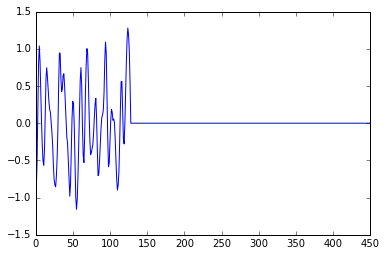

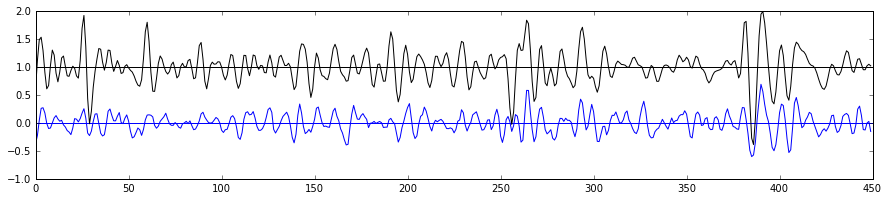

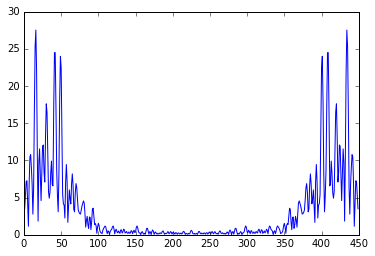

In [84]:
wavelet_size = 128# samples
opProj = np.zeros((r_crop.size, r_crop.size))
opProj[:wavelet_size, :wavelet_size] = np.eye(wavelet_size)
op  = np.dot(opConvolve, opProj)
wavelet = np.linalg.lstsq(op, trace)[0]
#w3_sm = np.hanning(nt)[nt//2:]*wavelet[:nt//2]
plt.plot(wavelet)
#plt.xlim([0,.1])

# Check out the seismic under this model
plt.figure(figsize=(15,3))
plt.plot(np.dot(op, wavelet))
plt.axhline(0)
plt.plot(1+trace, 'k')
plt.axhline(1, color='k')

plt.ylim(-1,2)

# Check the spectra
plt.figure()
plt.plot(np.abs(np.fft.fft(wavelet)))


In [85]:
s3 = np.dot(op, w3)

Sweet spectra, but it came at the cost of adding a large reflection at the end of the data. Anyways, there are a billion different ways to re-formulate the least-squares problem. It's actually at bit addictive.

Take home: The basic convolution model can't fit the data. There are multiples, processing issues, and migrations effects that aren't accounted. Because the model is wrong we are going to get a wrong answer, so we use regularization and other optimization tricks so we at least get a wrong answer that looks legit.

Something else to think about: This is synthetic data, and things are already messy and uncertain for even the simplest inversion. Things are obviously going to be total non-sense on real data. More complicated inversions like Shuey-terms, FWI, least-squares RTM... get real ;).

## 4. Wavelet estimation by Wiener filter

### Inverse Problem
Pretend we don't know our wavelet and we have reflectivity from the log and a well tie trace from the seismic. How do we recover the wavelet?

First recognize that convolution is a linear operator, and therefore we can write it as a matrix-vector product:

trace = C*wavelet

Where C is a Toepplitz matrix constructed from the reflectivity

### Toeplitz matrix
A Toepplitz matrix has the property that each row is a shifted version of the one above. Since convolutions are just shifted inner products, there linear operators are Toepplitz matrices. 

### Inversion 
Notice that our convolution matrix isn't square, so we can't simply invert it.
ie:

`Cw=trace`

`w=inv(C)trace`

So we solve the system using least squares. Notice the np.dot for our inner products. Julia and MATLAB use * as the default for inner products, making the syntax better for this kind of stuff.

Or how it was explained in the Strata package, we can solve for the psuedo inverse, which is the analytically solution to least squares:

`Cw=trace`

`(Ct)Cw=(Ct)trace`

`w = inv(CtC)(Ct)trace`

CtC is the covariance matrix

### Plot wavelets

In [86]:
%run wavelet_utils/wavelet_utils.py

/Users/Evan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


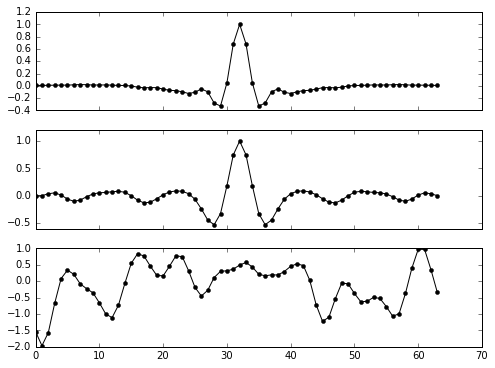

In [89]:
### Two subplots, the axes array is 1-d
wavelets = [w1, norm(w2), w3]
labels = ['Ormsby', 'Autocorrelation', 'Spectral Division']
f, axarr = plt.subplots(len(wavelets), sharex=True,figsize=(8,6))
for i, w in enumerate(wavelets):
    axarr[i].plot(w[:64],'ko-', ms=4)

# Make synthetics

/Users/Evan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


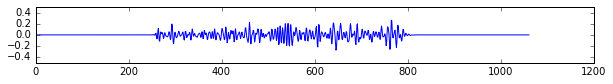

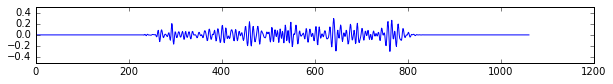

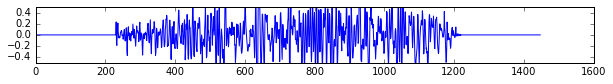

In [91]:
s1 =  np.convolve(w1, r, mode='full')  # visual
s2 =  np.convolve(norm(w2), r, mode='full')  # autocorrelation
s3 =  np.convolve(w3, r, mode='full')  # spectral division

synthetics = [s1,s2,s3]

for s in synthetics:
    plt.figure(figsize=(10,1))
    plt.plot(s)
    plt.ylim(-0.5,0.5)

# Correlations

In [92]:
def plot_traces(ax, data, tbase, ntraces=3, gain=1, dtr = 1.0, xlim=(-1.0,0), ylim=(0,4.0), ylabel=False, norm=True, points=False):
    if points:
        point = 'ko-'
    else:
        point = 'k'
    for i in range(ntraces):
        ax.plot(dtr*i + gain*data, tbase, point)
        ax.fill_betweenx(tbase, dtr*i + gain*data,  dtr*i, data > 0.0,  color='k', alpha = 1.0)

        #ax.axvline(dtr*i, color='k', lw=0.5)
    ax.set_xlim((xlim[0],xlim[1]+ntraces))
    ax.set_ylim((ylim[0],ylim[1]))
    ax.invert_yaxis()
    if ylabel:
        ax.set_ylabel('time (s)')
    ax.set_xticks([])
    #ax.axis('off')
    return ax

# Get some tops for reference

In [120]:
tops = {'Abenaki': [2.417, 3374],
 'Base O-Marker': [1.953, 2439],
 'Dawson Canyon': [0.939, 954],
 'L Baccaro': [2.827, 3934],
 'L Missisauga': [2.311, 3160],
 'Logan Canyon': [1.064, 1107],
 'Mid Baccaro': [2.476, 3455],
 'U Missisauga': [1.817, 2221],
 'Wyandot': [0.859, 837],}

In [121]:
t2d(837)

array(859.1708984400001)

In [94]:
t1 = np.arange(n1,n1+len(s1),1)*dt

In [95]:
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

/Users/Evan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


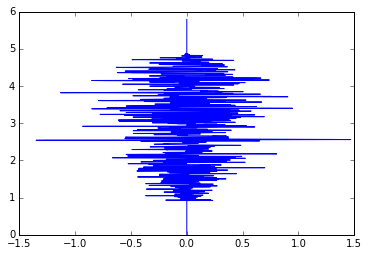

In [102]:
plt.plot(s3, np.arange(0,len(s3),1)*dt)

correlation start time:  1.0
correlation end time:  2.6


ValueError: x and y must have same first dimension

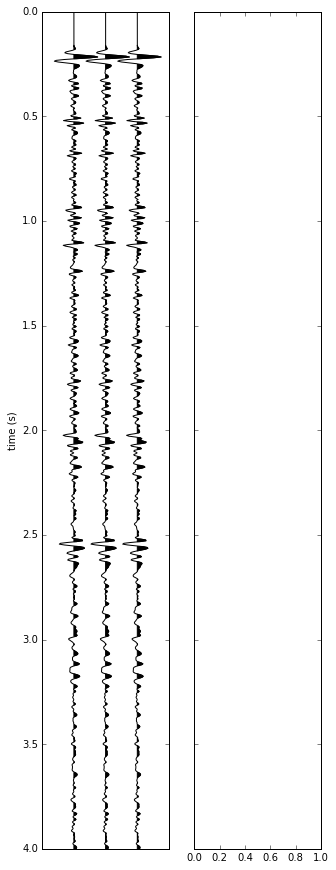

In [104]:
# Plot params

top_t = 0.0  # start time of plot
base_t = 4.0  # end time of plot

# plotting stuff
@interact(c1=(0, 750), c2=(0,750), x=(0,300))
def plot_synthetics(c1=250,c2=400, x=100):
    traces = [norm(data[:,x]), norm(s3)] #, s3] #s2, s3, s4]
    trace_labels = ['Data', 'Synthetic', 'Synthetic', 'Synthetic'] #, 'Spectral Div.', 'Wiener']
    scalar = 0.75
    gain = scalar*np.array([1, 1, 1, 1, 1])

    # Correlation params
    print ('correlation start time: ', c1*dt)
    print ('correlation end time: ', dt*(c1+c2))
    ccff = []
    for signal in traces[1:]:
        ccff.append(np.corrcoef(abs(traces[0])[c1:c1+c2],abs(signal)[c1:c1+c2])[0][1])

    f, axarr = plt.subplots(1,len(traces), sharey=True,figsize=(5,15))
    
    for i, d in enumerate(traces):
        ylabel = False
        if i==0:
            # PLOT DATA
            ylabel = True
            plot_traces(axarr[i],norm(data[:,100]),np.arange(0,len(data[:,100]),1)*dt,
                        gain = gain[i],
                        ylabel=ylabel, 
                        norm=False)
        if i==1:
            plot_traces(axarr[i],d, np.arange(0,len(d),1)*dt,
                        gain = gain[i],
                        ylabel=ylabel, 
                        norm=False)
        else:
            # PLOT TRACE
            plot_traces(axarr[i], d, np.arange(0,len(s3),1)*dt,
                        gain = gain[i],
                        ylabel=ylabel, 
                        norm=False)
        axarr[i].set_xlabel(trace_labels[i])
        #axarr[i].set_ylim((base_t,top_t))

        for name, twt in tops.items():
            axarr[i].axhline(y = float(twt), color = 'b', lw = 2, 
                             alpha = 0.5, xmin = 0.05, xmax = 0.95)
            if i == len(traces)-1:
                axarr[i].text(x = 5, y = float(twt), s = name,
                          alpha=0.75, color='k',
                          fontsize = '10',
                          horizontalalignment = 'left',
                          verticalalignment = 'center',
                          bbox=dict(facecolor='white', alpha=0.25, lw = 0.5),
                          weight = 'light')

        axarr[i].add_patch(patches.Rectangle((-1.5, c1*dt),6.5,c2*dt, alpha=0.15, fc='r'))

        axarr[i].axhline(y = c1*dt, color = 'r', lw = 2, 
                        alpha = 0.5, xmin = 0.05, xmax = 0.95)
        axarr[i].axhline(y = (c1+c2)*dt, color = 'r', lw = 2, 
                        alpha = 0.5, xmin = 0.05, xmax = 0.95)
        if i != 0:
            axarr[i].text(x = 1.95, y = (c1-10)*dt, s = "{:.2f}".format(ccff[i-1]),
                          alpha=1.0, color='k',
                          fontsize = '14',
                          horizontalalignment = 'center',
                          verticalalignment = 'bottom',
                          bbox=dict(facecolor='white', ec='r', alpha=0.85, lw = 0.5),
                          weight = 'normal')
            
            axarr[i].text(x = 1.95, y = (c1-30)*dt, s = "Correl Coeff.",
                          alpha=1.0, color='k',
                          fontsize = '10',
                          horizontalalignment = 'center',
                          verticalalignment = 'bottom',
                          bbox=dict(facecolor='white', ec='r', alpha=0.85, lw = 0.5),
                          weight = 'normal')